# Email Threat Detection System 🕵️‍♂️

It's not always easy to know whether a file you've downloaded and are preparing to execute is malicious.  How can we be better-prepared to tell the difference between benign and malicious executable files?

## The Goal:

Create a deep neural network, using tensorflow, with the intent on classifying image representations of portable executable files (PEs) so that, going forward, we can get a better understanding of the risk in opening files we get from unknown authors.

The 'benign' PEs were pulled from PC Magazine's [The Best Free Software of 2020](https://www.pcmag.com/news/best-free-software). The 'malicious' PEs were pulled from [the zoo](https://github.com/ytisf/theZoo).

Link to Kaggle dataset [here](https://www.kaggle.com/datasets/matthewfields/malware-as-images)!

## Prepare our workspace

Let's import our dependancies, confirm working versions of those dependancies, set random seeds, and list any workspace variables that we will likely reuse throughput the notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_hub as hub
import os
import shutil
import cv2
import datetime
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split

2023-11-16 18:18:30.454653: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print('TF Version: ', tf.__version__)
print('TF Hub Version: ', hub.__version__)
print('Pandas Version: ', pd.__version__)
print('Numpy Version: ', np.__version__)

TF Version:  2.14.0
TF Hub Version:  0.15.0
Pandas Version:  1.5.3
Numpy Version:  1.24.3


## Create common variables

In [3]:
MEASUREMENT = 'lanczos'
DPI = "300"
IMAGE_SIZE = 224
WORKSPACE_BASE_URL = '../data/raw/'
PROCESSED_IMAGE_DIRECTORY = '../data/processed/processed_images'
RANDOM_STATE = 42

## Set random seeds for reproducability

In [4]:
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Create dataframe containing filenames and label as malicious

In [5]:
# create helper function to generate dataframe containing filnames and labels
def create_df(measurement=MEASUREMENT, dpi=DPI):
  """
  collect names of files according to measurement and DPI
  create dataframe for filenames and labels
  """
  # collect pathnames
  benign_path = f'{WORKSPACE_BASE_URL}/portable_executables/benign/{measurement}_{dpi}'
  malicious_path = f'{WORKSPACE_BASE_URL}/portable_executables/malicious/{measurement}_{dpi}'
  # collect filenames
  benign_filenames = os.listdir(benign_path)
  malicious_filenames = os.listdir(malicious_path)
  # create dataframes
  df_benign = pd.DataFrame(benign_filenames, columns=['file_names'])
  df_malicious = pd.DataFrame(malicious_filenames, columns=['file_names'])
  # add labels
  df_benign['status'] = 'benign'
  df_malicious['status'] = 'malicious'
  # retrun concatonated dataframe
  return pd.concat([df_benign, df_malicious], ignore_index=True)

In [6]:
# create a dataframe
df = create_df()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_names  137 non-null    object
 1   status      137 non-null    object
dtypes: object(2)
memory usage: 2.3+ KB


In [7]:
# confirm there are no duplicates
len(df[df.duplicated()]) == 0

True

## Visualizing the distribution of each status type

In [8]:
# Let's make a helper function to visualize this
def plot_status_distribution(dataframe):
    # Calculating the value counts and the percentage of each category
    value_counts = dataframe['status'].value_counts()
    percent = value_counts / value_counts.sum() * 100

    # Creating a bar plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(percent.index.map(str.upper), percent, color=['red' if x == 'malicious' else 'green' for x in percent.index])

    # Adding the distribution percentage on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # Va='bottom' to place the text at the top of the bar

    # Setting labels and title
    plt.xlabel('Status')
    plt.ylabel('Percentage (%)')
    plt.title('Distribution of Status Categories')

    # Showing the plot
    plt.show()

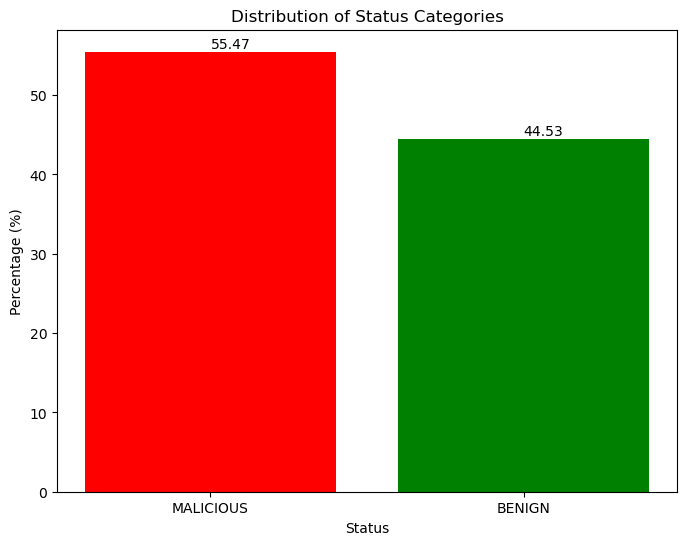

In [9]:
plot_status_distribution(df)

These label counts are slightly off balance, but not to the extent that this should pose a serious problem.

We may want to circle back in our `create_df` helper function to ensure these classes are properly balanced.

## Visualizing our images

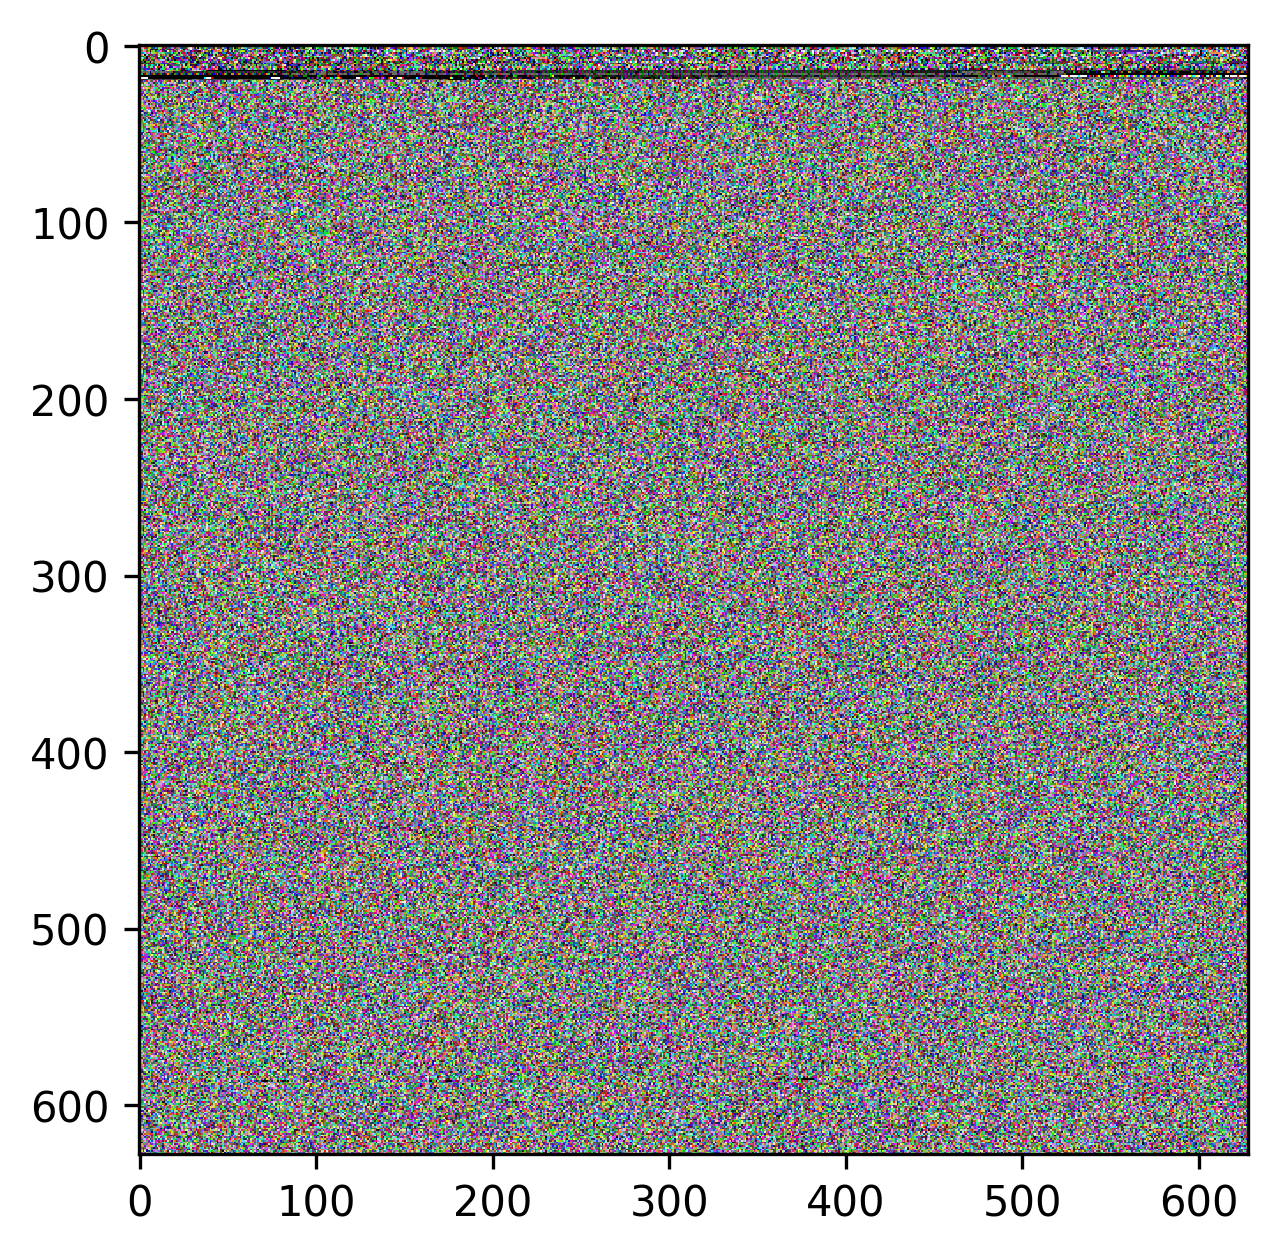

In [10]:
# Let's view an image within the notebook
from IPython.display import Image
Image(f"{WORKSPACE_BASE_URL}/portable_executables/benign/nearest_300/7z1900_nearest_300_.png")

This is a fairly large image.  We will likley have to downscale it and force dimension sizes on it.

Also, these images contain axis and margins that may confuse our model.  Perhaps we can strip these axis away?

In [11]:
# let's create a helper function to preprocess these images and put them in a common directory
def process_images(
    measurement=MEASUREMENT,
    dpi=DPI,
    size=(IMAGE_SIZE, IMAGE_SIZE),
    trim_axis=True
):
  """
  gathers image files from both benign and malicious file directories,
  optionally remove axis imformation from the image
  resize the image to desired width & height
  distribute all files in processed images directory
  """
  # collect source directories
  source_dirs = [
      f'{WORKSPACE_BASE_URL}/portable_executables/benign/{measurement}_{dpi}',
      f'{WORKSPACE_BASE_URL}/portable_executables/malicious/{measurement}_{dpi}'
  ]
  # create destination directory
  destination_dir = PROCESSED_IMAGE_DIRECTORY

  # Remove the directory if it exists
  if os.path.exists(destination_dir):
    shutil.rmtree(destination_dir)

  # Create the directory
  os.makedirs(destination_dir)

  # process each image
  for source_dir in source_dirs:
    for file_name in os.listdir(source_dir):
        file_path = os.path.join(source_dir, file_name)

        # Check if it's a file and not a directory
        if os.path.isfile(file_path):
            # Read the image
            image = cv2.imread(file_path)

            # optionally remove axis from image
            if trim_axis:
              # Convert to grayscale and threshold to isolate the spectrogram
              gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
              _, thresholded = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

              # Find contours and get the largest one which should be the spectrogram
              contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
              largest_contour = max(contours, key=cv2.contourArea)

              # Get bounding box of the largest contour
              x, y, w, h = cv2.boundingRect(largest_contour)

              # Crop the image to the bounding box
              image = image[y:y+h, x:x+w]

            # Resize the cropped image
            resized_image = cv2.resize(image, size)

            # Save the processed image to the destination directory
            cv2.imwrite(os.path.join(destination_dir, file_name), resized_image)


In [12]:
process_images()

now that we have our images processed, let's update our dataframe to include the base path for that processed images directory

In [13]:
df['file_names'].iloc[0]

'scribus-1.4.8-windows_lanczos_300_.png'

In [14]:
df['file_names'] = f"{PROCESSED_IMAGE_DIRECTORY}/" + df['file_names']
df['file_names'].iloc[0]

'../data/processed/processed_images/scribus-1.4.8-windows_lanczos_300_.png'

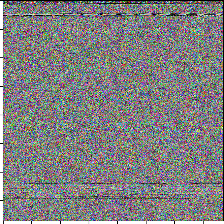

In [15]:
# let's view one of our processed images
impath = f'{PROCESSED_IMAGE_DIRECTORY}/Tojan.NSIS.Win32_lanczos_300_.png'
Image(impath)

Great!  We can confirm the axis have been cut off and the image has been trimmed in size.

## Exploratory Data Analysis

### Color Distribution Analysis

A good way to get a sense of how our `benign` samples differ from `malicious` ones is to plot the distribution of pixel intensities for each class

#### Pixel intensity for single image samples

In [16]:
# define a helper function to abstract this logic so it can be applied to both samples
def plot_color_histogram(image_path, title="Color Histogram"):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    # Split into channels
    R, G, B = cv2.split(image)

    # Compute histograms for each channel
    histR = cv2.calcHist([R], [0], None, [256], [0, 256])
    histG = cv2.calcHist([G], [0], None, [256], [0, 256])
    histB = cv2.calcHist([B], [0], None, [256], [0, 256])

    # Plot the histograms
    plt.figure(figsize=(10, 4))
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.plot(histR, color='red')
    plt.plot(histG, color='green')
    plt.plot(histB, color='blue')

    plt.xlim([0, 256])
    plt.show()

##### For random 'benign' sample

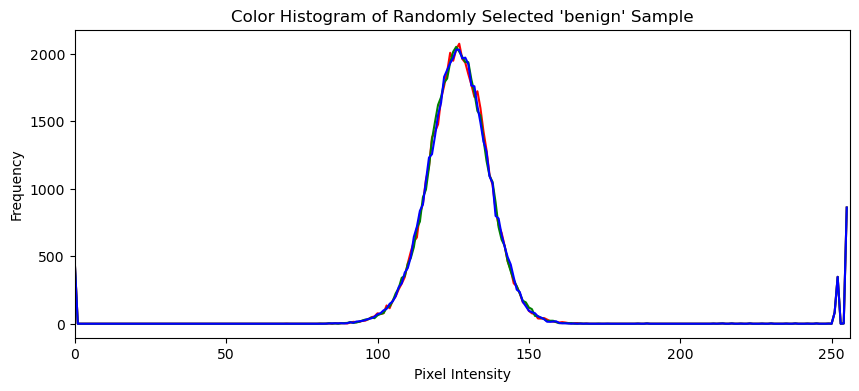

In [17]:
random_benign_entry = df[df['status'] == 'benign']['file_names'].sample(n=1).iloc[0]
plot_color_histogram(
    random_benign_entry,
    title="Color Histogram of Randomly Selected 'benign' Sample"
)

##### For random 'malicious' sample

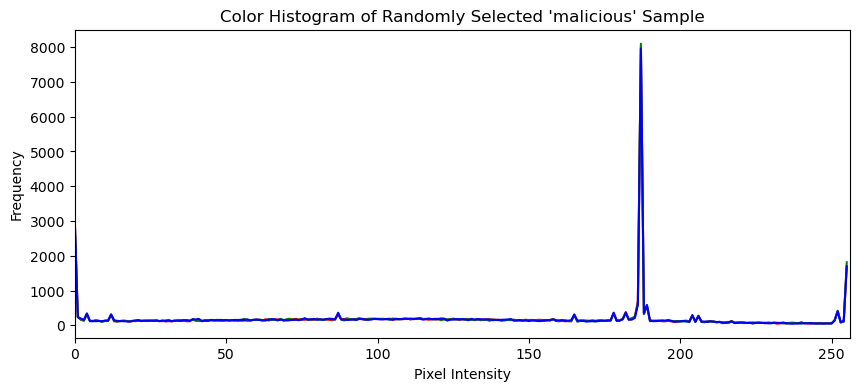

In [18]:
random_benign_entry = df[df['status'] == 'malicious']['file_names'].sample(n=1).iloc[0]
plot_color_histogram(
    random_benign_entry,
    title="Color Histogram of Randomly Selected 'malicious' Sample"
)

### Visualize color historgrams as an average per class

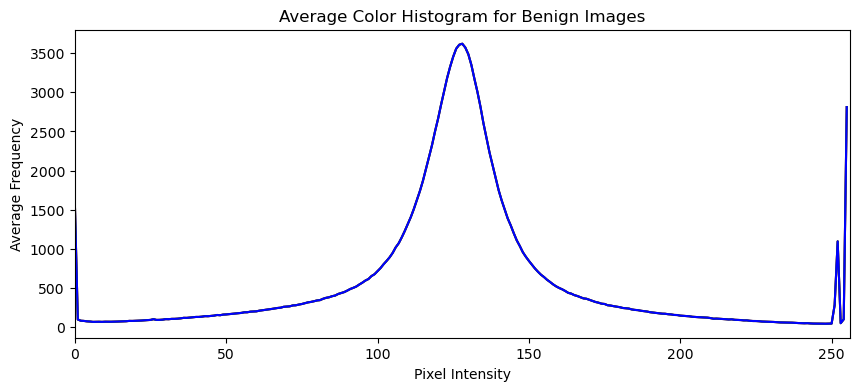

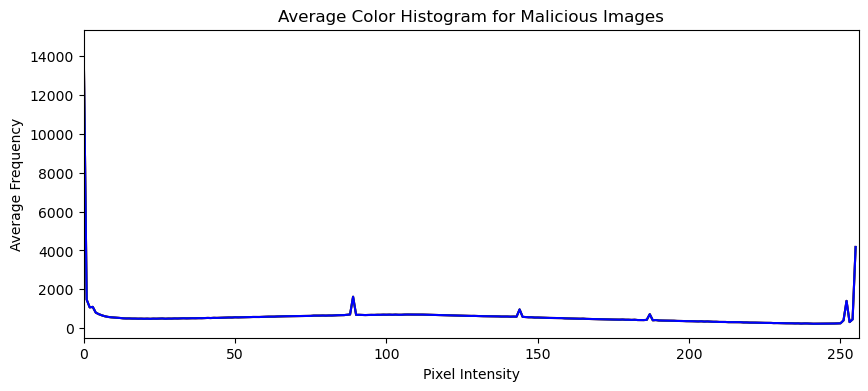

In [19]:
def compute_average_histogram(df, status):
    # Initialize sum of histograms
    sum_histR = sum_histG = sum_histB = np.zeros((256, 1), dtype='float32')

    # Filter dataframe for the given status
    df_status = df[df['status'] == status]

    for image_path in df_status['file_names']:
        # Read and process the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Split into channels and compute histograms
        R, G, B = cv2.split(image)
        sum_histR += cv2.calcHist([R], [0], None, [256], [0, 256])
        sum_histG += cv2.calcHist([G], [0], None, [256], [0, 256])
        sum_histB += cv2.calcHist([B], [0], None, [256], [0, 256])

    # Compute average histograms
    avg_histR = sum_histR / len(df_status)
    avg_histG = sum_histG / len(df_status)
    avg_histB = sum_histB / len(df_status)

    return avg_histR, avg_histG, avg_histB

def plot_histograms(histR, histG, histB, title):
    plt.figure(figsize=(10, 4))
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Average Frequency")
    plt.plot(histR, color='red')
    plt.plot(histG, color='green')
    plt.plot(histB, color='blue')
    plt.xlim([0, 256])
    plt.show()

# Compute and plot histograms for 'benign' class
avg_histR_benign, avg_histG_benign, avg_histB_benign = compute_average_histogram(df, 'benign')
plot_histograms(avg_histR_benign, avg_histG_benign, avg_histB_benign, "Average Color Histogram for Benign Images")

# Compute and plot histograms for 'malicious' class
avg_histR_malicious, avg_histG_malicious, avg_histB_malicious = compute_average_histogram(df, 'malicious')
plot_histograms(avg_histR_malicious, avg_histG_malicious, avg_histB_malicious, "Average Color Histogram for Malicious Images")

### Generating synthetic data
As we only have so many images available to us, it may pay off to generate flipped or rotated versions of these images to train on.

Before we generate this data, we should carve out a holdout set so that we can test our model against images that are as close as possible to ground truth.

In [23]:
train_valid_df, holdout_df = train_test_split(
    df,
    test_size=0.10, 
    stratify=df['status'],
    random_state=RANDOM_STATE
)
train_valid_df.head()

file_names     status
123  ../data/processed/processed_images/KRBanker_Cr...  malicious
34   ../data/processed/processed_images/setup-light...     benign
136  ../data/processed/processed_images/W32.HLLP.Ha...  malicious
116  ../data/processed/processed_images/KRBanker_HD...  malicious
86   ../data/processed/processed_images/Variant.Kaz...  malicious

In [24]:
holdout_df.head()

file_names     status
107  ../data/processed/processed_images/W32.Elkern....  malicious
38   ../data/processed/processed_images/image_resiz...     benign
95   ../data/processed/processed_images/Boaxxe_lanc...  malicious
51   ../data/processed/processed_images/FileZilla_3...     benign
131  ../data/processed/processed_images/Zherkov_lan...  malicious

Let's check the distrubution of our labels against these sets

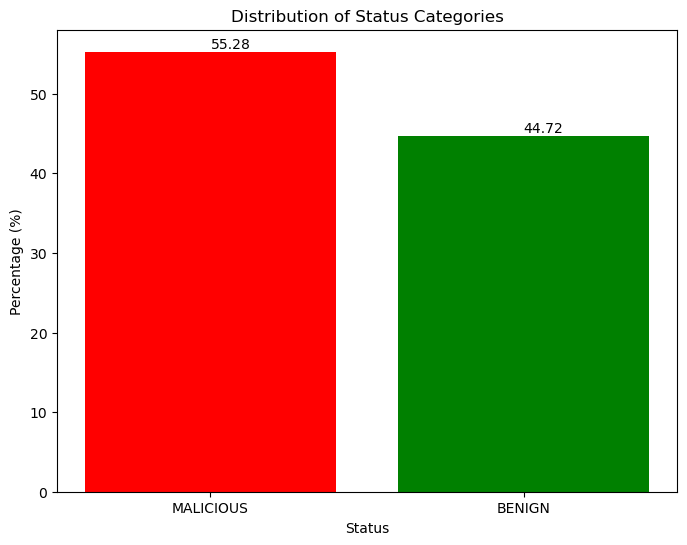

In [25]:
plot_status_distribution(train_valid_df)

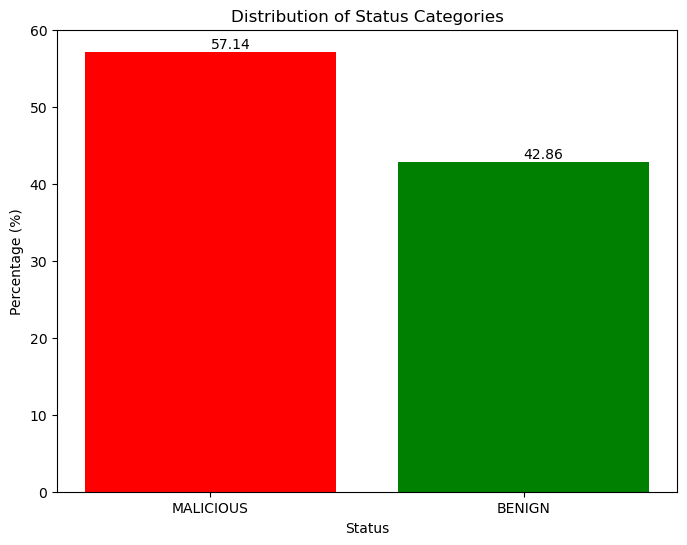

In [26]:
plot_status_distribution(holdout_df)

Great!  This is about as close as we can hope for!

In [27]:
# Let's check if the number of entries we have in our dataframe
# match the number of images we just processed
filenames = os.listdir(PROCESSED_IMAGE_DIRECTORY)
if len(df) == len(filenames):
    print('it matches -- proceed!')
else:
  print('they do not match -- check for error!')
len(df), len(filenames)

it matches -- proceed!


(137, 137)

In [28]:
df.head()

file_names  status
0  ../data/processed/processed_images/scribus-1.4...  benign
1  ../data/processed/processed_images/Boxcryptor_...  benign
2  ../data/processed/processed_images/MYKI-latest...  benign
3  ../data/processed/processed_images/ks4.021.2.1...  benign
4  ../data/processed/processed_images/unchecky_se...  benign

In [29]:
# shuffled_df = df.sample(frac=1).reset_index(drop=True)

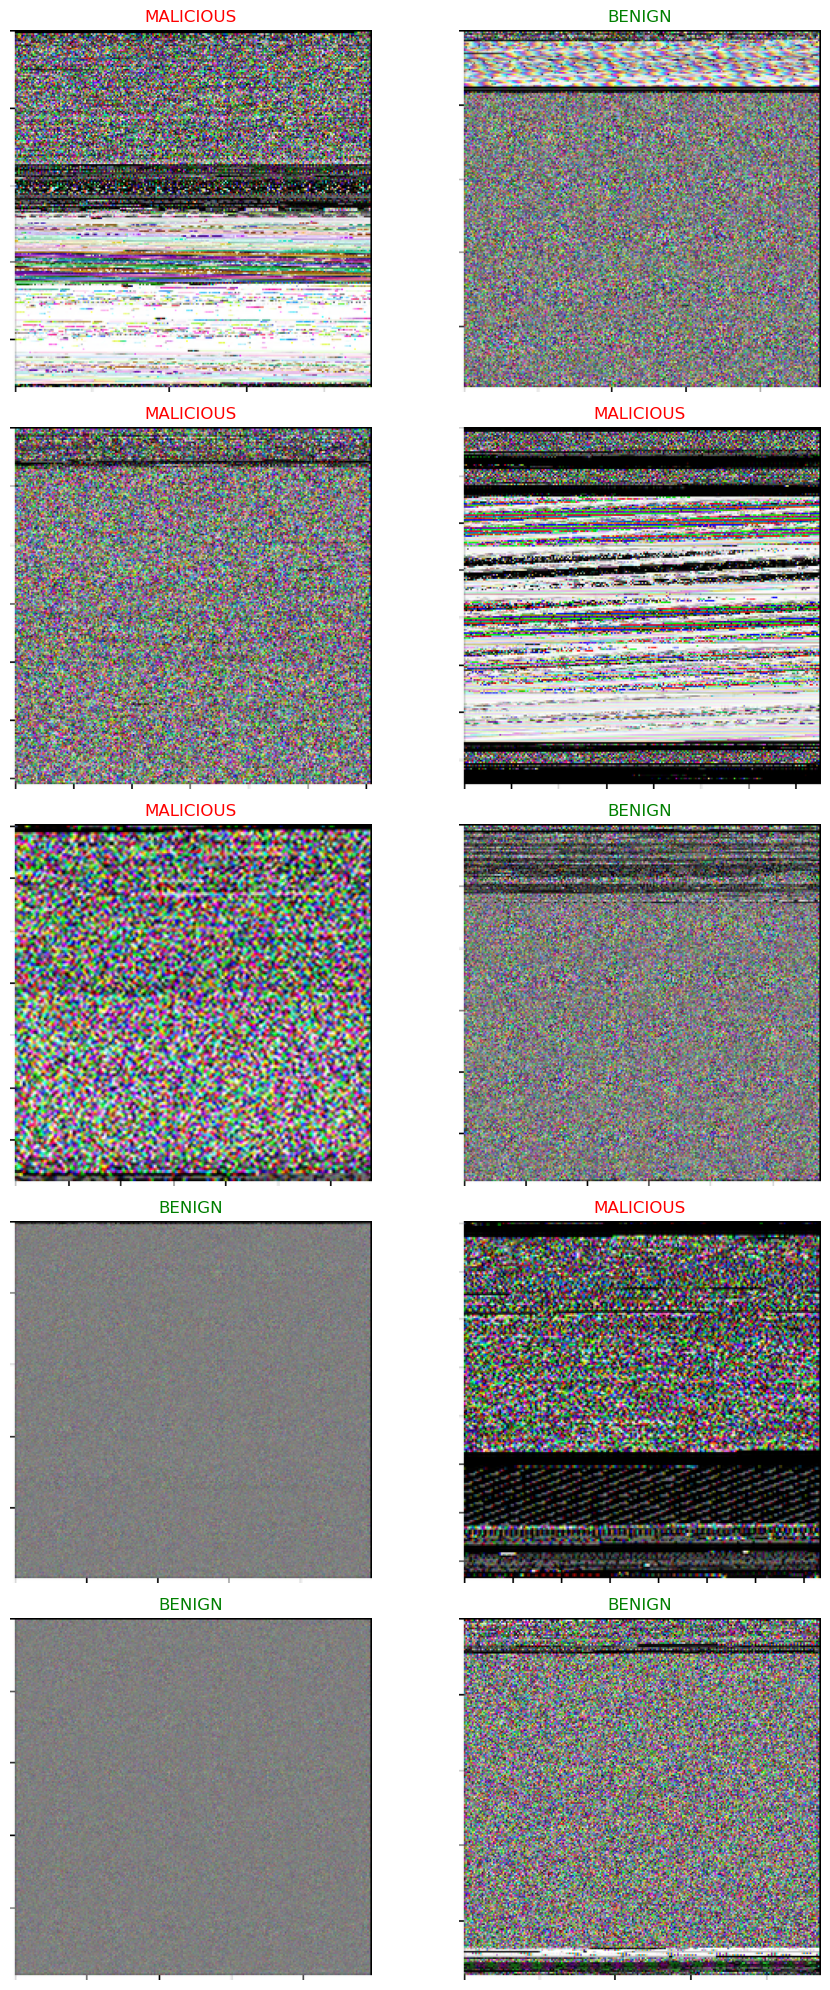

In [30]:
# Create a grid for plotting (5 rows, 2 columns)
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

# Flatten the axes array for easy iteration
axs = axs.ravel()

# Loop over the first 10 rows of the DataFrame
for idx, row in enumerate(train_valid_df.head(10).itertuples()):
    file_name = getattr(row, 'file_names')
    is_malicious = getattr(row, 'status') == 'malicious'

    # Load and display the image
    img = mpimg.imread(file_name)
    axs[idx].imshow(img)
    axs[idx].axis('off')  # Turn off axis

    # Display label
    label = "MALICIOUS" if is_malicious == True else "BENIGN"
    color = 'red' if is_malicious == True else 'green'
    axs[idx].set_title(f"{label}", color=color)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Create our own train, valid and test sets

now that we know the image paths we have in our dataframe can be accessed, we now need to create train and test sets

In [31]:
labels = train_valid_df['status'].to_numpy()
filenames = train_valid_df['file_names'].tolist()

In [32]:
# check if number of lables matches lenth of filenames
if len(labels) == len(filenames):
    print('it matches -- proceed!')
else:
  print('they do not match -- check for error!')

it matches -- proceed!


In [33]:
# get list of unique lables
unique_labels = np.unique(labels)
unique_labels

array(['benign', 'malicious'], dtype=object)

In [34]:
# the goal here is to have our 'y' be comprosed of an array of booleans 
# corresponding to each unique label
print(labels[0])
labels[0] == unique_labels

malicious


array([False,  True])

In [35]:
# Turn every label into a boolean array
boolean_labels = [label == unique_labels for label in labels]
boolean_labels[:2]

[array([False,  True]), array([ True, False])]

The goal here is to transofrm these boolean labels into a list of numbers that correspond to a 1 for true and a 0 for false

In [36]:
print(labels[0]) # origional label
print(filenames[0]) # corresponding filename
print(np.where(unique_labels == labels[0])) # index where label occours
print(boolean_labels[0].argmax()) # index where label occours in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occours

malicious
../data/processed/processed_images/KRBanker_CretClient.exe_lanczos_300_.png
(array([1]),)
1
[0 1]


In [37]:
filenames[:2]

['../data/processed/processed_images/KRBanker_CretClient.exe_lanczos_300_.png',
 '../data/processed/processed_images/setup-lightshot_lanczos_300_.png']

In [38]:
boolean_labels[:2]

[array([False,  True]), array([ True, False])]

this looks good -- I think we're ready to split our data into train and validation sets

In [39]:
X = filenames
y = boolean_labels
len(X), len(y)

(123, 123)

In [40]:
# First split: Separate out the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.10, random_state=RANDOM_STATE
)

# Second split: Separate the training set and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=RANDOM_STATE
)

# Now, X_train and y_train are for training, X_val and y_val are for validation, 
# and X_test and y_test are for testing
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(88, 88, 22, 22, 13, 13)

In [41]:
# Let's have a look at the training data
X_train[:1], y_train[:1]

(['../data/processed/processed_images/7z1900_lanczos_300_.png'],
 [array([ True, False])])

### Turning our images into tensors
*   Take an image file path as input
*   Use Tensorflow to read the file and save it to a variable
*   Turn our image into Tensors
*   Resize the image to be a shape of `IMAGE_SHAPE` variable
*   return the modified image

In [42]:
# check the shape of any given image
image = imread(X[42])
image.shape

(224, 224, 3)

In [43]:
# check min and max values
image.min(), image.max()

(0.0, 1.0)

In [44]:
# turn image into a tensor
tf.constant(image)

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.99607843, 0.99607843, 0.99607843],
        [0.99607843, 0.99607843, 0.99607843],
        [0.9764706 , 0.9764706 , 0.9764706 ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.8392157 , 0.8392157 , 0.8392157 ],
        [0.8392157 , 0.8392157 , 0.8392157 ],
        [0.83137256, 0.83137256, 0.83137256],
        ...,
        [0.5686275 , 0.08235294, 0.        ],
        [0.6431373 , 0.49019608, 0.        ],
        [0.        , 0.        , 0.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.9882353 , 0.9882353 , 0.9882353 ],
        ...,
        [0.8901961 , 0.36862746, 0.00784314],
        [0.3137255 , 0.8235294 , 0.30588236],
        [0.        , 0.        , 0.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.  

In [45]:
# create a helper function for preproceesing the a single image
def process_image(image_path, img_size=IMAGE_SIZE):
  """
  Takes an image path and returns an image as a Tensor
  """
  # Take an image file path as input
  # Use Tensorflow to read the file and save it to a variable
  image = tf.io.read_file(image_path)
  # Turn our image into Tensors
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the colour channel from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to be a shape of 224 X 224
  image = tf.image.resize(image, size=[img_size, img_size])
  # return the modified image
  return image

In [46]:
# create a helper function to create a tuple of tensors
def get_image_label(image_path, label):
  """
  Takes an image path name and associated label, and returns a tuple with image and associated label
  """
  image = process_image(image_path)
  return image, label

In [47]:
# demo of the above
(process_image(X[42]), y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         [0.97647065, 0.97647065, 0.97647065],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.83921576, 0.83921576, 0.83921576],
         [0.83921576, 0.83921576, 0.83921576],
         [0.8313726 , 0.8313726 , 0.8313726 ],
         ...,
         [0.5686275 , 0.08235294, 0.        ],
         [0.6431373 , 0.4901961 , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [0.98823535, 0.98823535, 0.98823535],
         ...,
         [0.89019614, 0.36862746, 0.00784314],
         [0.3137255 , 0.8235295 , 0.30588236],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[1.        , 1.        

### Create data batches

Now we've got a way to turn our data into tuples of tensors in the form of (image, label)

Let's make a function to turn all of our data into batches.

In [48]:
# define the batch size
BATCH_SIZE = 32

# create a funciton to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of image X and label y pairs.
  It shuffles the data if it's training data, but does not shuffle if it's validation or test data.
  It also accepts test data with no labels
  """

  # If the data is a test dataset, we don't have lables
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths -- no labels
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  # if it's a valid dataset, we do not need to shuffle it
  elif valid_data:
    print('Creating valid data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) # including both file paths and labels
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  else:
    print('Creating training data batches...')
    # Turn file paths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((
        tf.constant(X),
        tf.constant(y)
    )) # including both file paths and labels
    # shuffle path names and labels prior to mapping is faster than mapping unpacked image tensors
    data = data.shuffle(buffer_size=len(X))

    data = data.map(get_image_label)
    data_batch = data.batch(batch_size)
    return data_batch

In [49]:
# Create training, validation and test batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)
test_data = create_data_batches(X_test, y_test, test_data=True)

Creating training data batches...
Creating valid data batches...
Creating test data batches...


In [50]:
# Check out the data attricbutes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)))

In [51]:
# we can see that each batch has a length of 32, as we have defined in BATCH_SIZE
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

### Visualizing data batches

In [52]:
def show_image_block(
    images,
    labels,
    num_images=15
):
  """
  Displays a block of images and their lables form a data batch
  """
  # set up the figure
  plt.figure(figsize=(10, 10))
  # Loop through num_images for diplaying the images
  for i in range(num_images):
    # Create subplots
    ax = plt.subplot(5, 5, i + 1)
    # Display an image
    plt.imshow(images[i])
    # Determine the label and convert to uppercase
    label = unique_labels[labels[i].argmax()].upper()
    # Set the title color based on the label value
    title_color = 'green' if label == 'BENIGN' else 'red'
    # Add the image label as the title
    plt.title(label, color=title_color)
    # Turn the grid lines off
    plt.axis('off')

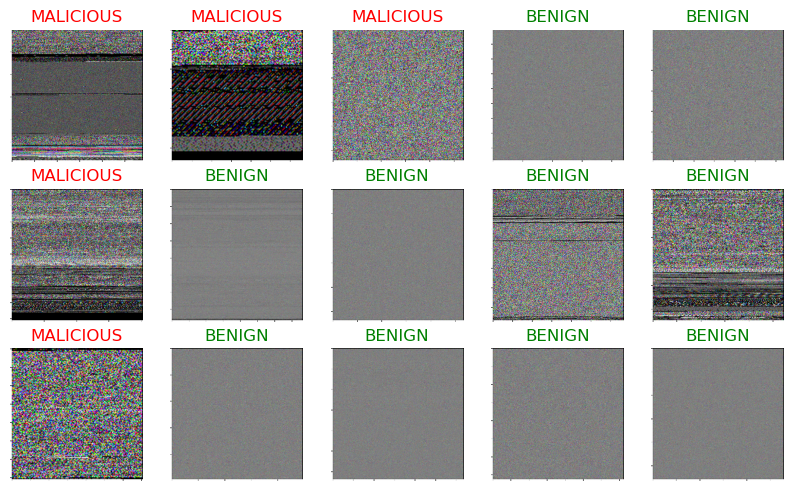

In [53]:
# let's visualize the data in a training batch
show_image_block(train_images, train_labels)

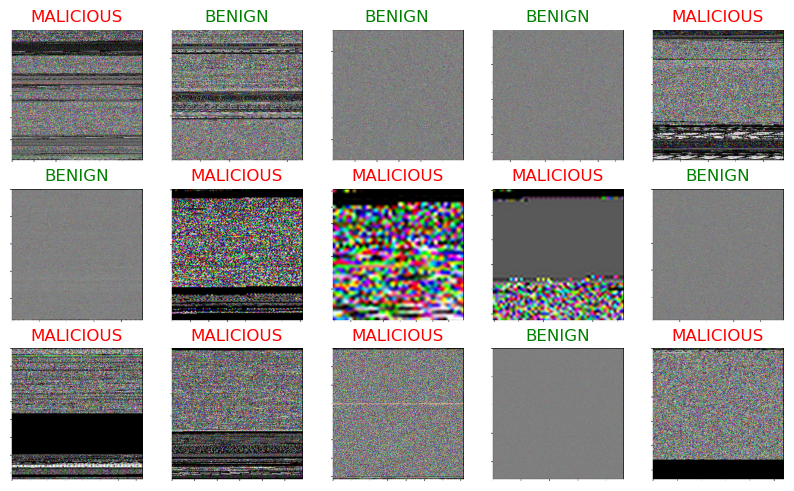

In [54]:
# and a validation batch
val_images, val_labels = next(val_data.as_numpy_iterator())
show_image_block(val_images, val_labels)

### Building a model

Before we build a model, there are a few things we need to define.

1.  the input shape -- our images shape in the form of tensors
2.  the ourput shape -- image labels in the form of tensors
3.  the URL fo the model we want to use from [Tensorflow Hub](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5)

In [55]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3] # batch, height, width, colour channels

# set up the output shape
OUTPUT_SHAPE = len(unique_labels)

# set up URL from tensorflow hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5' # Udemy vido has /4... consider changing this if issues occour RE: versions

In [56]:
# create a function which builds a keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print(f"Building a model with {model_url}")
  # set up the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url), # layer one, the input layer
      tf.keras.layers.Dense(units=output_shape, activation="softmax") # Later two, the output layer
  ])
  # compile the model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy']
  )
  # build the model
  model.build(input_shape)
  return model

In [57]:
model = create_model()
model.summary()

Building a model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 2)                 2004      
                                                                 
Total params: 5434717 (20.73 MB)
Trainable params: 2004 (7.83 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


### Create callbacks
We should create two basic callbacks for when we train our model
1.   tensorboard
2.   early-stopping

In [58]:
# load tensorboard notebook extension
%load_ext tensorboard

In [59]:
# create a function to build a tensorboard callback
def create_tensorboard_callback():
  # create a log directory for storing tensorboard logs
  logdir = os.path.join(
      '../reports/tensorboard_logs',
      # make it so the logs get tracked whenever we run an experiment
      datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  )
  return tf.keras.callbacks.TensorBoard(logdir)

In [60]:
# create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3
)

### Create a function that trains a model

1. create a model using create_model function
2. create a tensorboard callback using create_tensorboard_callback
3. call the .fit() method on the model using the training data, validation data, number of epochs to train for and the callbacks, which are the helper functions we would like to use.
4. return the model

In [61]:
NUM_EPOCHS = 100
# build a function to train, and return the trained model
def train_model():
  """
  trains a given model, and returns the trained version
  """
  # create a model
  model = create_model()

  # create a new tensorboard session every time we train a model
  tensorboard = create_tensorboard_callback()

  # fit the data to the model, passing it the callbacks we created
  model.fit(
      x=train_data,
      epochs=NUM_EPOCHS,
      validation_data=val_data,
      validation_freq=1,
      callbacks=[tensorboard, early_stopping]
  )

  return model

In [62]:
# fit our model to the data
model = train_model()

Building a model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
3/3 [==============================] - 6s 998ms/step - loss: 0.8061 - accuracy: 0.5455 - val_loss: 0.3788 - val_accuracy: 0.8636
Epoch 2/100
3/3 [==============================] - 2s 803ms/step - loss: 0.4476 - accuracy: 0.7955 - val_loss: 0.2314 - val_accuracy: 0.9545
Epoch 3/100
3/3 [==============================] - 2s 803ms/step - loss: 0.3848 - accuracy: 0.8068 - val_loss: 0.2041 - val_accuracy: 0.9091
Epoch 4/100
3/3 [==============================] - 2s 737ms/step - loss: 0.3456 - accuracy: 0.8182 - val_loss: 0.1876 - val_accuracy: 0.9091
Epoch 5/100
3/3 [==============================] - 2s 742ms/step - loss: 0.3227 - accuracy: 0.8523 - val_loss: 0.1696 - val_accuracy: 0.9091
